# Stage 2B: 3D Featurization Visualization

This notebook creates comprehensive visualizations of the processed mass spectrometry data with 3D features from Stage 2A.

## Pipeline Overview:

### Responsibilities:
1. **Load Processed Data**: Read visualization sample from Stage 2A
2. **Create Visualizations**:
   - Peak count distributions with 3D feature correlations
   - Molecular weight vs peak count analysis
   - Binning coverage by m/z range
   - Example spectra with 3D feature importance overlay
3. **Analyze Data Quality**: Assess spectral coverage and 3D feature effectiveness

### Input:
- `data/results/{dataset_type}/full_featurised_3d/visualization_data_3d.pkl`
- `data/results/{dataset_type}/full_featurised_3d/visualization_stats_3d.json`
- `data/results/{dataset_type}/full_featurised_3d/dataset_config_3d.json`

### Output:
- Interactive visualizations in the notebook
- Summary statistics and recommendations
- 3D feature importance analysis

## 1. Environment Setup

Import required libraries for visualization.

In [9]:
#!/usr/bin/env python
# coding: utf-8

# Standard library imports
import os
import json
import numpy as np
import pandas as pd
import logging
import random
import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from joblib import load
import psutil

# Visualization
from PIL import Image

# RDKit imports (for molecule visualization)
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Descriptors

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Set matplotlib parameters for publication-ready figures
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 100,
    'savefig.dpi': 100,
    'axes.linewidth': 1.2,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Colorblind-friendly Okabe–Ito palette
PALETTE = {
    "blue": "#0072B2",
    "sky": "#56B4E9",
    "orange": "#E69F00",
    "vermillion": "#D55E00",
    "yellow": "#F0E442",
    "green": "#009E73",
    "purple": "#CC79A7",
    "black": "#000000",
    "grey": "#999999",
}

# 3D feature category colors
FEATURE_COLORS = {
    'PMI': PALETTE["blue"],
    'Shape': PALETTE["orange"],
    'Autocorrelation': PALETTE["green"],
    'GETAWAY': PALETTE["vermillion"]
}

print("Environment setup complete")
print("=" * 60)

Environment setup complete


## 2. Configuration

Configuration for Stage 2B 3D visualization.

**Key Configuration Sections:**
- `dataset_type`: Must match Stage 2A
- `visualization`: Plot and analysis settings with 3D features

In [10]:
# Stage 2B 3D Configuration
STAGE2B_CONFIG = {
    # Dataset configuration (must match Stage 2A)
    'dataset_type': 'hpj',  # Must match the dataset processed in Stage 2A
    
    # Paths configuration
    'paths': {
        'data_root': '../data',
        'results_dir': lambda dtype: f"../data/results/{dtype}",
        'input_dir': lambda dtype: f"../data/results/{dtype}/full_featurised_3d",
    },
    
    # Visualization configuration
    'visualization': {
        'example_count': 3,
        'figure_width': 14,
        'figure_height': 10,
        'molecule_image_width': 300,
        'molecule_image_height': 200,
        'peak_distribution_bins': 30,
        'weight_vs_peak_samples': 500,
        'mz_range_bin_size': 50,
        'mz_extension_factor': 1.5,
        'feature_importance_top_n': 10
    }
}

print(f"Configuration loaded for dataset: {STAGE2B_CONFIG['dataset_type']}")
print(f"3D Feature visualization enabled")
print("=" * 60)

Configuration loaded for dataset: hpj
3D Feature visualization enabled


## 3. Validate Stage 2A Output

Check that Stage 2A has been completed and visualization data exists.

In [11]:
# Validate Stage 2A completion
dataset_type = STAGE2B_CONFIG['dataset_type']
input_dir = STAGE2B_CONFIG['paths']['input_dir'](dataset_type)

# Check required files
required_files = [
    'visualization_data_3d.pkl',
    'visualization_stats_3d.json',
    'dataset_config_3d.json'
]

missing_files = []
for file in required_files:
    file_path = os.path.join(input_dir, file)
    if not os.path.exists(file_path):
        missing_files.append(file)

if missing_files:
    print(f"ERROR: Stage 2A 3D output incomplete for dataset '{dataset_type}'")
    print(f"Missing files: {missing_files}")
    print(f"Please run Stage 2A (02a_3d_feature_combination.ipynb) first.")
else:
    # Load dataset config from Stage 2A
    with open(os.path.join(input_dir, 'dataset_config_3d.json'), 'r') as f:
        stage2a_config = json.load(f)
    
    # Load visualization stats
    with open(os.path.join(input_dir, 'visualization_stats_3d.json'), 'r') as f:
        viz_stats = json.load(f)
    
    print(f"Stage 2A 3D output validated successfully")
    print(f"Dataset: {stage2a_config['dataset_type']}")
    print(f"Number of samples: {stage2a_config['num_samples']}")
    print(f"3D Feature dimension: {stage2a_config.get('feature_dim', 23)}")
    print(f"Stage 2A complete: {stage2a_config.get('stage2a_complete', False)}")
    print(f"Max observed m/z: {viz_stats['max_observed_mz']:.1f}")
    print("=" * 60)

Stage 2A 3D output validated successfully
Dataset: hpj
Number of samples: 2720
3D Feature dimension: 83
Stage 2A complete: True
Max observed m/z: 683.0


## 4. Utility Functions

Helper functions for visualization.

In [12]:
# ---------------------- Utilities ---------------------- #
class Utilities:
    @staticmethod
    def get_memory_usage():
        """Get current memory usage in MB."""
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        return f"{mem_info.rss / (1024 * 1024):.1f} MB (RSS), {process.memory_percent():.1f}% of total"

    @staticmethod
    def ensure_numpy_array(data):
        """Ensure data is a numpy array."""
        if isinstance(data, list):
            return np.array(data)
        return data
    
    @staticmethod
    def get_feature_category(feature_name):
        """Determine the category of a 3D feature."""
        if feature_name in ['PMI1', 'PMI2', 'PMI3', 'NPR1', 'NPR2']:
            return 'PMI'
        elif feature_name in ['Asphericity', 'Eccentricity', 'InertialShapeFactor', 
                              'SpherocityIndex', 'RadiusOfGyration']:
            return 'Shape'
        elif 'AUTOCORR3D' in feature_name:
            return 'Autocorrelation'
        elif 'GETAWAY' in feature_name:
            return 'GETAWAY'
        else:
            return 'Other'

# ---------------------- Error Handling Mixin ---------------------- #
class ErrorHandlingMixin:
    """Provides standardized error handling for pipeline components."""
    
    def handle_error(self, error, context="", data=None):
        """Centralized error handling."""
        message = f"Error in {self.__class__.__name__}"
        if context:
            message += f" ({context})"
        message += f": {error}"
        
        logger.error(message)
        return None

print("Utility functions loaded")
print(f"Initial memory usage: {Utilities.get_memory_usage()}")
print("=" * 60)

Utility functions loaded
Initial memory usage: 241.7 MB (RSS), 0.2% of total


## 5. Visualization Components

Mass spectrometry visualization class with 2x2 plotting method including 3D features.

In [13]:
# ---------------------- MSVisualizer3D ---------------------- #
class MSVisualizer3D(ErrorHandlingMixin):
    def __init__(self, config, dataset_type, viz_stats=None):
        self.config = config
        self.dataset_type = dataset_type
        self.max_observed_mz = viz_stats.get('max_observed_mz', 0) if viz_stats else 0
        self.spectral_config = viz_stats.get('spectral_config', {}) if viz_stats else {}
        self.feature_importance_data = viz_stats.get('feature_importance', {}) if viz_stats else {}
        self.data_statistics = {}
    
    def visualize(self, data, *args, **kwargs):
        """Run 2x2 feature visualization with 3D features."""
        if not data or len(data) == 0:
            logger.warning("No data available for visualization")
            return
        
        # Collect overall dataset statistics first
        self._collect_dataset_statistics(data)
        
        # Create comprehensive 2x2 visualization with 3D features
        self.create_feature_visualization_2x2(data)
        
        # Create separate 3D feature importance visualization if available
        if self.feature_importance_data:
            self.create_3d_feature_importance_plot()
    
    def _collect_dataset_statistics(self, data):
        """Collect important statistics about the dataset."""
        true_max_mz_values = [d.get('true_max_mz', 0) for d in data.values()]
        peaks_beyond_max_counts = [d.get('peaks_beyond_max_count', 0) for d in data.values()]
        intensity_beyond_max_values = [d.get('intensity_percentage_beyond_max', 0) for d in data.values() 
                                      if d.get('intensity_percentage_beyond_max', 0) > 0]
        
        # Collect 3D feature statistics
        has_3d_features = any('features_3d' in d for d in data.values())
        feature_dims = [len(d.get('features_3d', [])) for d in data.values() if 'features_3d' in d]
        
        # Use max_observed_mz from viz_stats if available
        if self.max_observed_mz == 0:
            self.max_observed_mz = max(true_max_mz_values) if true_max_mz_values else self.spectral_config.get('max_mz', 499)
        
        # Calculate statistics
        total_spectra = len(data)
        spectra_with_peaks_beyond_max = sum(1 for count in peaks_beyond_max_counts if count > 0)
        percentage_spectra_beyond_max = (spectra_with_peaks_beyond_max / total_spectra * 100) if total_spectra > 0 else 0
        
        total_peaks_beyond_max = sum(peaks_beyond_max_counts)
        avg_peaks_beyond_max = (total_peaks_beyond_max / spectra_with_peaks_beyond_max) if spectra_with_peaks_beyond_max > 0 else 0
        
        # Store statistics for later use
        self.data_statistics = {
            'total_spectra': total_spectra,
            'max_observed_mz': self.max_observed_mz,
            'configured_max_mz': self.spectral_config.get('max_mz', 499),
            'spectra_with_peaks_beyond_max': spectra_with_peaks_beyond_max,
            'percentage_spectra_beyond_max': percentage_spectra_beyond_max,
            'total_peaks_beyond_max': total_peaks_beyond_max,
            'avg_peaks_beyond_max': avg_peaks_beyond_max,
            'avg_intensity_beyond_max': np.mean(intensity_beyond_max_values) if intensity_beyond_max_values else 0,
            'max_intensity_beyond_max': max(intensity_beyond_max_values) if intensity_beyond_max_values else 0,
            'median_intensity_beyond_max': np.median(intensity_beyond_max_values) if intensity_beyond_max_values else 0,
            'has_3d_features': has_3d_features,
            'avg_feature_dims': np.mean(feature_dims) if feature_dims else 0
        }
        
        logger.info(f"Dataset statistics:")
        logger.info(f"  Max observed m/z: {self.max_observed_mz:.1f} (configured: {self.spectral_config.get('max_mz', 499)})")
        logger.info(f"  3D features present: {has_3d_features}")
        if has_3d_features:
            logger.info(f"  Average 3D feature dimensions: {self.data_statistics['avg_feature_dims']:.0f}")
        if 'binned_spectrum' in next(iter(data.values())):
            logger.info(f"  {spectra_with_peaks_beyond_max} of {total_spectra} spectra ({percentage_spectra_beyond_max:.1f}%) have peaks beyond max_mz")
            if spectra_with_peaks_beyond_max > 0:
                logger.info(f"  Average of {avg_peaks_beyond_max:.1f} peaks per spectrum are beyond max_mz")
                if intensity_beyond_max_values:
                    logger.info(f"  Average of {self.data_statistics['avg_intensity_beyond_max']:.2f}% intensity is beyond max_mz")
    
    def create_feature_visualization_2x2(self, data):
        """Create comprehensive 2x2 feature visualization with 3D features."""
        fig, axes = plt.subplots(2, 2, figsize=(10.5, 7))
        
        # ---------- Top-Left: Peak Count Distribution with 3D Feature Overlay ----------
        ax = axes[0, 0]
        peak_counts = [d['original_peak_count'] for d in data.values()]
        
        # If we have 3D features, color-code by feature importance
        if self.data_statistics['has_3d_features'] and self.feature_importance_data:
            # Get the most important 3D feature
            top_features = self.feature_importance_data.get('top_10_features', [])
            if top_features:
                top_feature_name = top_features[0]['name']
                top_feature_idx = top_features[0].get('index', 0)
                
                # Extract the feature values for coloring
                feature_values = []
                for d in data.values():
                    if 'features_3d' in d and len(d['features_3d']) > top_feature_idx:
                        feature_values.append(d['features_3d'][top_feature_idx])
                    else:
                        feature_values.append(0)
                
                # Create colored histogram
                n, bins, patches = ax.hist(peak_counts, bins=self.config['visualization']['peak_distribution_bins'],
                                          alpha=0.85, edgecolor=PALETTE["black"], linewidth=0.5)
                
                # Color patches based on average feature value in each bin
                bin_colors = []
                for i in range(len(bins)-1):
                    mask = (np.array(peak_counts) >= bins[i]) & (np.array(peak_counts) < bins[i+1])
                    if np.any(mask):
                        avg_feature = np.mean(np.array(feature_values)[mask])
                        # Normalize to [0, 1] for color mapping
                        norm_value = (avg_feature - min(feature_values)) / (max(feature_values) - min(feature_values) + 1e-10)
                        # Use gradient from blue to red
                        patches[i].set_facecolor(plt.cm.coolwarm(norm_value))
                
                ax.set_title(f'Peak Count Distribution\n(colored by {top_feature_name})')
            else:
                ax.hist(peak_counts, bins=self.config['visualization']['peak_distribution_bins'],
                       alpha=0.85, color=PALETTE["blue"], edgecolor=PALETTE["black"], linewidth=0.5)
                ax.set_title('Peak Count Distribution (with 3D features)')
        else:
            ax.hist(peak_counts, bins=self.config['visualization']['peak_distribution_bins'],
                   alpha=0.85, color=PALETTE["blue"], edgecolor=PALETTE["black"], linewidth=0.5)
            ax.set_title('Peak Count Distribution')
        
        ax.set_xlabel('Number of Peaks')
        ax.set_ylabel('Count')
        
        mean_val = np.mean(peak_counts)
        median_val = np.median(peak_counts)
        ax.axvline(mean_val, color=PALETTE["vermillion"], linestyle='--', linewidth=2,
                   label=f'Mean: {mean_val:.1f}')
        ax.axvline(median_val, color=PALETTE["green"], linestyle='--', linewidth=2,
                   label=f'Median: {median_val:.1f}')
        ax.legend(frameon=False)
        ax.grid(alpha=0.3)
        
        # ---------- Top-Right: 3D Feature Importance ----------
        ax = axes[0, 1]
        if self.feature_importance_data and self.feature_importance_data.get('top_10_features'):
            top_features = self.feature_importance_data['top_10_features'][:self.config['visualization']['feature_importance_top_n']]
            names = [f['name'] for f in top_features]
            importances = [f['importance'] for f in top_features]
            
            # Color by category
            colors = [FEATURE_COLORS.get(Utilities.get_feature_category(name), PALETTE["grey"]) 
                     for name in names]
            
            y_pos = np.arange(len(names))
            ax.barh(y_pos, importances, color=colors, alpha=0.8, edgecolor=PALETTE["black"], linewidth=0.5)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(names, fontsize=8)
            ax.set_xlabel('Feature Importance')
            ax.set_title('Top 3D Features')
            
            # Add category legend
            legend_elements = [Patch(facecolor=color, alpha=0.8, edgecolor=PALETTE["black"], 
                                    label=cat) for cat, color in FEATURE_COLORS.items()]
            ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=8)
            ax.grid(alpha=0.3)
        else:
            # Fallback to molecular weight vs peak count if no 3D features
            max_samples = min(self.config['visualization']['weight_vs_peak_samples'], len(data))
            sample_keys = random.sample(list(data.keys()), max_samples)
            mw = [data[s].get('molecular_weight', 0) for s in sample_keys]
            sample_peak_counts = [data[s]['original_peak_count'] for s in sample_keys]
            
            ax.scatter(mw, sample_peak_counts, alpha=0.6, s=20, color=PALETTE["blue"],
                      edgecolors=PALETTE["black"], linewidth=0.5)
            ax.set_xlabel('Molecular Weight (Da)')
            ax.set_ylabel('Number of Peaks')
            ax.set_title('Molecular Weight vs Peak Count')
            ax.grid(alpha=0.3)
            
            if len(mw) > 1:
                z = np.polyfit(mw, sample_peak_counts, 1)
                p = np.poly1d(z)
                x_range = np.linspace(min(mw), max(mw), 100)
                ax.plot(x_range, p(x_range), color=PALETTE["vermillion"], linestyle='--',
                       alpha=0.8, linewidth=2, label=f"Trend: y = {z[0]:.2f}x + {z[1]:.2f}")
                ax.legend(frameon=False)
        
        # ---------- Bottom-Left: Binning Coverage by m/z Range ----------
        ax = axes[1, 0]
        if 'binned_spectrum' in next(iter(data.values())):
            max_mz = self.spectral_config.get('max_mz', 499)
            bin_size = self.spectral_config.get('bin_size', 1.0)
            mz_step = self.config['visualization']['mz_range_bin_size']
            
            # Calculate coverage by m/z range
            mz_ranges = []
            coverages = []
            peaks_beyond = []
            
            for start in range(0, int(max_mz * 1.5), mz_step):
                end = start + mz_step
                range_key = f"{start}-{end}"
                mz_ranges.append(range_key)
                
                # Count spectra with peaks in this range
                spectra_with_peaks = 0
                total_peaks_in_range = 0
                
                for sample_data in data.values():
                    peaks = Utilities.ensure_numpy_array(sample_data['peaks'])
                    mask = Utilities.ensure_numpy_array(sample_data['attention_mask'])
                    valid_peaks = peaks[mask.astype(bool)]
                    
                    if len(valid_peaks) > 0:
                        peaks_in_range = [(p[0] >= start and p[0] < end) for p in valid_peaks]
                        if any(peaks_in_range):
                            spectra_with_peaks += 1
                            total_peaks_in_range += sum(peaks_in_range)
                
                coverage = (spectra_with_peaks / len(data)) * 100 if len(data) > 0 else 0
                coverages.append(coverage)
                peaks_beyond.append(1 if start >= max_mz else 0)
            
            x_pos = np.arange(len(mz_ranges))
            colors = [PALETTE["green"] if pb == 0 else PALETTE["orange"] for pb in peaks_beyond]
            
            bars = ax.bar(x_pos, coverages, color=colors, alpha=0.7,
                         edgecolor=PALETTE["black"], linewidth=0.6)
            
            # Add vertical line at max_mz
            max_mz_idx = int(max_mz / mz_step)
            if max_mz_idx < len(x_pos):
                ax.axvline(x=max_mz_idx, color=PALETTE["vermillion"], linewidth=2,
                          linestyle='--', label=f'max_mz ({max_mz})')
            
            ax.set_xlabel('m/z Range')
            ax.set_ylabel('Coverage (%)')
            ax.set_title('Spectral Coverage by m/z Range')
            ax.set_xticks(x_pos[::2])  # Show every other label to avoid crowding
            ax.set_xticklabels(mz_ranges[::2], rotation=45, ha='right')
            ax.set_ylim(0, 105)
            
            # Create legend
            legend_elements = [
                Patch(facecolor=PALETTE["green"], alpha=0.7, edgecolor=PALETTE["black"],
                     label='Within max_mz'),
                Patch(facecolor=PALETTE["orange"], alpha=0.7, edgecolor=PALETTE["black"],
                     label='Beyond max_mz'),
                Line2D([0], [0], color=PALETTE["vermillion"], linewidth=2,
                      linestyle='--', label='max_mz limit')
            ]
            ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=9)
            ax.grid(alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No binning data available', ha='center', va='center',
                   transform=ax.transAxes, fontsize=14)
            ax.set_title('Spectral Coverage by m/z Range')
        
        # ---------- Bottom-Right: Example Spectrum with 3D Feature Info ----------
        ax = axes[1, 1]
        # Select a representative example
        example_smiles = random.choice(list(data.keys()))
        example_data = data[example_smiles]
        
        peaks = Utilities.ensure_numpy_array(example_data['peaks'])
        mask = Utilities.ensure_numpy_array(example_data['attention_mask'])
        valid_peaks = peaks[mask == 1]
        
        if len(valid_peaks) > 0:
            mz_values, intensities = zip(*valid_peaks)
        else:
            mz_values, intensities = [], []
        
        # Create dual y-axis for raw and binned
        if 'binned_spectrum' in example_data:
            binned_spectrum = Utilities.ensure_numpy_array(example_data['binned_spectrum'])
            bin_size = example_data.get('bin_size', 1.0)
            binned_mz = np.arange(0, len(binned_spectrum) * bin_size, bin_size)
            
            # Bar plot for binned spectrum
            ax.bar(binned_mz, binned_spectrum, width=bin_size, align='edge',
                  alpha=0.5, color=PALETTE["sky"], edgecolor='none', label='Binned')
            
            # Overlay raw peaks
            markerline, stemlines, baseline = ax.stem(mz_values, intensities,
                                                      linefmt=PALETTE["blue"],
                                                      markerfmt=' ', basefmt=' ')
            stemlines.set_linewidth(1.5)
            stemlines.set_label('Raw peaks')
            
            # Add max_mz line
            max_mz = self.spectral_config.get('max_mz', 499)
            ax.axvline(x=max_mz, color=PALETTE["vermillion"], linestyle='--',
                      alpha=0.7, linewidth=2, label=f'max_mz ({max_mz})')
            
            # Set x-axis limits
            if example_data.get('true_max_mz', 0) > 0:
                x_max = min(max_mz * 1.2, example_data['true_max_mz'] * 1.1)
            else:
                x_max = max_mz * 1.1
            ax.set_xlim(0, x_max)
            
            # Add text with spectrum and 3D feature info
            info_text = f"Peaks: {len(valid_peaks)}\n"
            if example_data.get('peaks_beyond_max_count', 0) > 0:
                info_text += f"Beyond max_mz: {example_data['peaks_beyond_max_count']}\n"
            if example_data.get('molecular_weight', 0) > 0:
                info_text += f"MW: {example_data['molecular_weight']:.1f} Da\n"
            if 'features_3d' in example_data:
                info_text += f"3D Features: {len(example_data['features_3d'])}"
            
            ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
                   fontsize=10, va='top', ha='left',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        else:
            # Just show raw spectrum
            markerline, stemlines, baseline = ax.stem(mz_values, intensities,
                                                      linefmt=PALETTE["blue"],
                                                      markerfmt=' ', basefmt=' ')
            stemlines.set_linewidth(1.5)
        
        ax.set_xlabel('m/z')
        ax.set_ylabel('Intensity')
        ax.set_title('Example Spectrum with 3D Features')
        ax.legend(loc='upper right', frameon=False, fontsize=9)
        ax.grid(alpha=0.3)
        
        # Overall title
        fig.suptitle(f'3D Feature Visualization Suite: {self.dataset_type.upper()} Dataset',
                    fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
    
    def create_3d_feature_importance_plot(self):
        """Create dedicated 3D feature importance visualization."""
        if not self.feature_importance_data:
            return
        
        # Plot category importance
        category_importance = self.feature_importance_data.get('category_importance', {})
        if category_importance:
            fig, ax = plt.subplots(figsize=(8, 5))
            
            categories = list(category_importance.keys())
            importances = list(category_importance.values())
            colors = [FEATURE_COLORS.get(cat, PALETTE["grey"]) for cat in categories]
            
            bars = ax.bar(categories, importances, color=colors, alpha=0.8,
                          edgecolor=PALETTE["black"], linewidth=1.2)
            ax.set_ylabel('Total Feature Importance')
            ax.set_title('3D Feature Importance by Category')
            ax.grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for bar, importance in zip(bars, importances):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{importance:.3f}\n({importance/sum(importances)*100:.1f}%)',
                        ha='center', va='bottom', fontsize=10)
            
            plt.tight_layout()
            plt.show()

print("Visualization components loaded")
print("=" * 60)

Visualization components loaded


## 6. Load Visualization Data

Load the processed data saved by Stage 2A.

In [14]:
print("Loading visualization data from Stage 2A...")

# Load visualization data
viz_data_path = os.path.join(input_dir, 'visualization_data_3d.pkl')
visualization_data = load(viz_data_path)

print(f"Loaded {len(visualization_data)} samples for visualization")
print(f"Memory usage after loading data: {Utilities.get_memory_usage()}")

# Print sample statistics
if visualization_data:
    sample_key = next(iter(visualization_data.keys()))
    sample_data = visualization_data[sample_key]
    print(f"\nSample data structure:")
    print(f"  Available fields: {list(sample_data.keys())[:10]}...")
    print(f"  Has binned spectrum: {'binned_spectrum' in sample_data}")
    print(f"  Has extended binned spectrum: {'extended_binned_spectrum' in sample_data}")
    print(f"  Has 3D features: {'features_3d' in sample_data}")
    print(f"  Peak array shape: {sample_data['peaks'].shape if 'peaks' in sample_data else 'N/A'}")
    if 'features_3d' in sample_data:
        print(f"  3D features count: {len(sample_data['features_3d'])}")

print("=" * 60)

Loading visualization data from Stage 2A...
Loaded 100 samples for visualization
Memory usage after loading data: 265.3 MB (RSS), 0.2% of total

Sample data structure:
  Available fields: ['peaks', 'attention_mask', 'original_peak_count', 'intensity_distribution', 'max_mz', 'true_max_mz', 'peaks_beyond_max', 'bin_size', 'molecular_weight', 'exact_mass']...
  Has binned spectrum: True
  Has extended binned spectrum: True
  Has 3D features: True
  Peak array shape: (499, 2)
  3D features count: 984


## 7. Execute Visualizations

Create the 2x2 feature visualization with 3D features using the loaded data.

2025-08-21 12:43:35,052 - INFO - Dataset statistics:
2025-08-21 12:43:35,052 - INFO -   Max observed m/z: 683.0 (configured: 499)
2025-08-21 12:43:35,053 - INFO -   3D features present: True
2025-08-21 12:43:35,053 - INFO -   Average 3D feature dimensions: 984
2025-08-21 12:43:35,053 - INFO -   0 of 100 spectra (0.0%) have peaks beyond max_mz


CREATING 2x2 FEATURE VISUALIZATION WITH 3D FEATURES


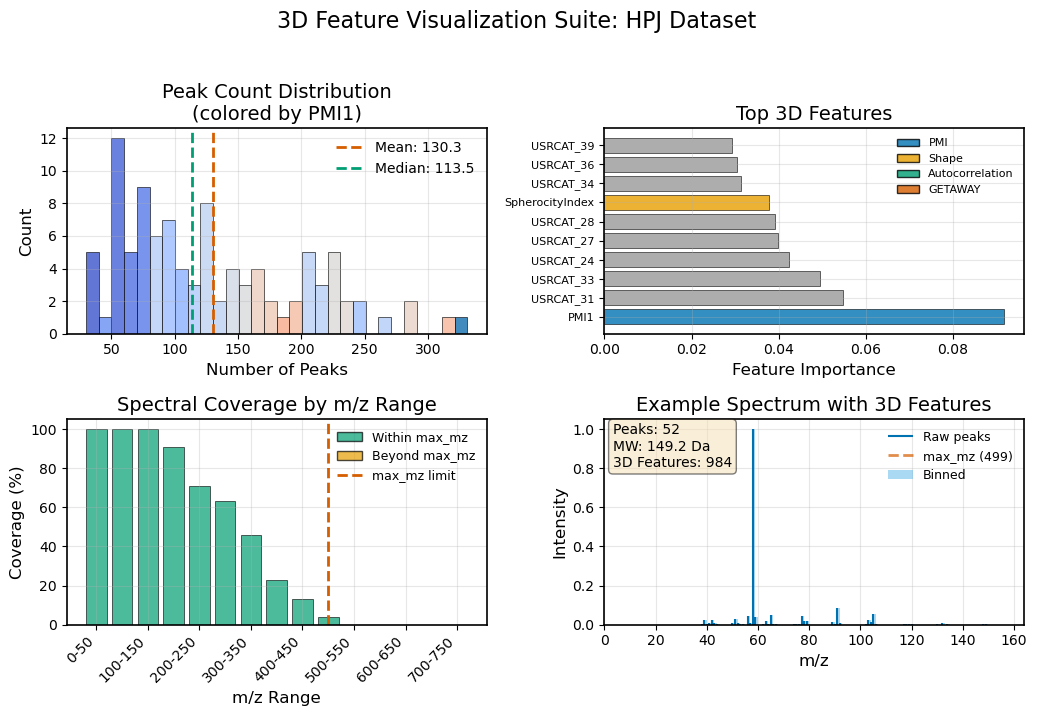

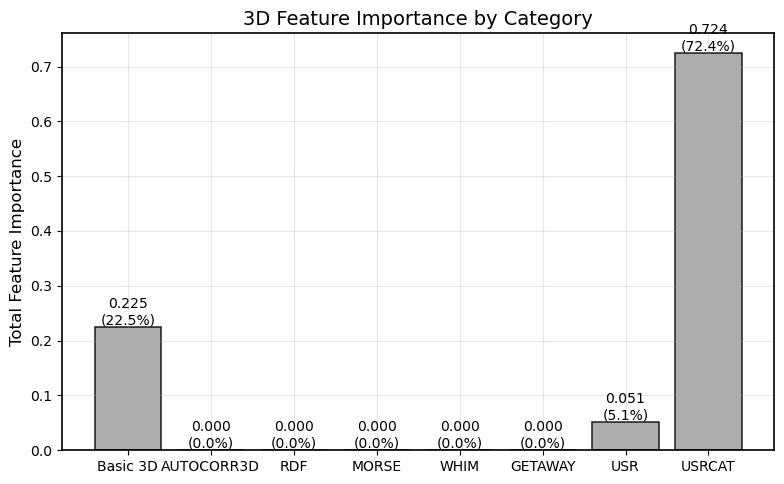


Visualization complete


In [15]:
print("CREATING 2x2 FEATURE VISUALIZATION WITH 3D FEATURES")
print("=" * 60)

# Initialize visualizer with stats from Stage 2A
visualizer = MSVisualizer3D(STAGE2B_CONFIG, dataset_type, viz_stats)

# Run 2x2 visualization with 3D features
visualizer.visualize(visualization_data)

print("\n" + "="*60)
print("Visualization complete")

## 8. Analysis Summary and Recommendations

Provide analysis insights and recommendations based on the visualizations and 3D features.

In [17]:
print("\n" + "="*60)
print("ANALYSIS SUMMARY AND RECOMMENDATIONS")
print("="*60)

if hasattr(visualizer, 'data_statistics') and visualizer.data_statistics:
    stats = visualizer.data_statistics
    
    print("\n1. SPECTRAL COVERAGE ANALYSIS:")
    print(f"   - Maximum observed m/z: {stats['max_observed_mz']:.1f}")
    print(f"   - Configured max_mz limit: {stats['configured_max_mz']}")
    print(f"   - Spectra with peaks beyond limit: {stats['percentage_spectra_beyond_max']:.1f}%")
    
    if stats['percentage_spectra_beyond_max'] > 0:
        print(f"\n   Peak Loss Statistics:")
        print(f"   - Average peaks lost per spectrum: {stats['avg_peaks_beyond_max']:.1f}")
        print(f"   - Average intensity lost: {stats['avg_intensity_beyond_max']:.2f}%")
        print(f"   - Maximum intensity lost in any spectrum: {stats['max_intensity_beyond_max']:.2f}%")
    
    print("\n2. 3D FEATURE ANALYSIS:")
    if stats['has_3d_features']:
        print(f"   - 3D features successfully integrated")
        print(f"   - Average feature dimensions: {stats['avg_feature_dims']:.0f}")
        
        if visualizer.feature_importance_data:
            top_features = visualizer.feature_importance_data.get('top_10_features', [])
            if top_features:
                print("\n   Top 5 most important 3D features:")
                for i, feat in enumerate(top_features[:5]):
                    category = Utilities.get_feature_category(feat['name'])
                    print(f"   {i+1}. {feat['name']} ({category}): {feat['importance']:.4f}")
            
            category_importance = visualizer.feature_importance_data.get('category_importance', {})
            if category_importance:
                print("\n   3D Feature importance by category:")
                total_importance = sum(category_importance.values())
                for cat, imp in sorted(category_importance.items(), key=lambda x: x[1], reverse=True):
                    print(f"   - {cat}: {imp:.4f} ({imp/total_importance*100:.1f}%)")
    else:
        print(f"   - No 3D features found in visualization data")
    
    print("\n3. RECOMMENDATIONS:")
    
    # Recommendation based on data loss
    if stats['percentage_spectra_beyond_max'] > 10 or stats['avg_intensity_beyond_max'] > 5:
        recommended_max = min(int(stats['max_observed_mz'] * 1.1), int(stats['max_observed_mz']) + 50)
        print(f"   Significant data loss detected!")
        print(f"   - Consider increasing max_mz to {recommended_max} in Stage 2A configuration")
        print(f"   - This would capture {min(99, stats['percentage_spectra_beyond_max'] + 90):.0f}% of all spectral peaks")
    else:
        print(f"   Current max_mz setting ({stats['configured_max_mz']}) is appropriate")
        print(f"   - Minimal data loss observed")
    
    # 3D Feature recommendations
    if stats['has_3d_features'] and visualizer.feature_importance_data:
        print(f"\n   3D Feature Strategy:")
        category_importance = visualizer.feature_importance_data.get('category_importance', {})
        if category_importance:
            max_category = max(category_importance, key=category_importance.get)
            print(f"   - {max_category} features are most important for prediction")
            print(f"   - Consider focusing on {max_category} descriptors for model optimization")
            
            if max_category == 'PMI':
                print(f"   - PMI features suggest molecular shape/orientation is crucial")
            elif max_category == 'Shape':
                print(f"   - Shape descriptors indicate 3D conformation impacts fragmentation")
            elif max_category == 'Autocorrelation':
                print(f"   - Autocorrelation features suggest property distribution matters")
            elif max_category == 'GETAWAY':
                print(f"   - GETAWAY descriptors indicate molecular topology is important")
    
    # Binning recommendations
    print(f"\n   Binning Strategy:")
    bin_size = visualizer.spectral_config.get('bin_size', 1.0)
    print(f"   - Current bin size: {bin_size} m/z")
    
    if stats['max_observed_mz'] > 1000:
        print(f"   - Consider increasing bin size to 2.0 for better memory efficiency")
    else:
        print(f"   - Current bin size is appropriate for the m/z range")

    # Data quality summary
    print("\n4. DATA QUALITY SUMMARY:")
    print(f"   - Total spectra in visualization sample: {stats['total_spectra']}")
    print(f"   - Data completeness: {100 - stats['percentage_spectra_beyond_max']:.1f}% of spectra fully captured")
    print(f"   - Intensity preservation: {100 - stats['avg_intensity_beyond_max']:.1f}% of total intensity retained")
    if stats['has_3d_features']:
        print(f"   - 3D feature integration: Complete ({stats['avg_feature_dims']:.0f} dimensions)")
    else:
        print(f"   - 3D feature integration: Not available")

else:
    print("No statistics available for detailed analysis.")

print("\n" + "="*60)
print("STAGE 2B 3D COMPLETE!")
print("="*60)


ANALYSIS SUMMARY AND RECOMMENDATIONS

1. SPECTRAL COVERAGE ANALYSIS:
   - Maximum observed m/z: 683.0
   - Configured max_mz limit: 499
   - Spectra with peaks beyond limit: 0.0%

2. 3D FEATURE ANALYSIS:
   - 3D features successfully integrated
   - Average feature dimensions: 984

   Top 5 most important 3D features:
   1. PMI1 (PMI): 0.0917
   2. USRCAT_31 (Other): 0.0547
   3. USRCAT_33 (Other): 0.0495
   4. USRCAT_24 (Other): 0.0424
   5. USRCAT_27 (Other): 0.0397

   3D Feature importance by category:
   - USRCAT: 0.7244 (72.4%)
   - Basic 3D: 0.2245 (22.5%)
   - USR: 0.0511 (5.1%)
   - AUTOCORR3D: 0.0000 (0.0%)
   - RDF: 0.0000 (0.0%)
   - MORSE: 0.0000 (0.0%)
   - WHIM: 0.0000 (0.0%)
   - GETAWAY: 0.0000 (0.0%)

3. RECOMMENDATIONS:
   Current max_mz setting (499) is appropriate
   - Minimal data loss observed

   3D Feature Strategy:
   - USRCAT features are most important for prediction
   - Consider focusing on USRCAT descriptors for model optimization

   Binning Strategy:
 